In [21]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
SAVEFIG = True

### Input a set of sine waves

In [22]:
# Initializing matrix
num_nodes = 1000
np.random.seed(2)

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

In [23]:
# define targets
time_points = np.arange(6000)
targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5

# input basis functions
np.random.seed(2)
inputs = []
for i in range(num_nodes):
    freq = np.random.randint(10, 100)
    phase = np.random.randint(0, 100)
    this_row = np.sin((time_points-phase)/freq*np.pi)/4 + 0.5
    inputs.append(this_row)
inputs = np.array(inputs)

In [24]:
# plt.plot(inputs.T[0:20, 0:50])

In [25]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = [1]*excite_num + [-1]*(num_nodes-excite_num)
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = 250
inh_weight_sum = 250
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [26]:
network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
        timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), shiftout=-2.5, gainout=1.15, target=inputs, basisset=True)
states, activations, outputs = network.simulate(120)

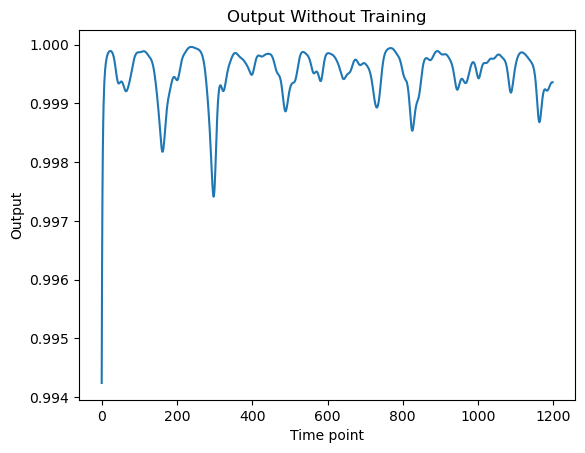

In [27]:
plt.plot(outputs)
plt.ylabel("Output")
plt.xlabel("Time point")
plt.title("Output Without Training")
if SAVEFIG:
    plt.savefig("fig/FORCE_wavebasis_outputnotrain.png")

Text(0.5, 0, 'Time point')

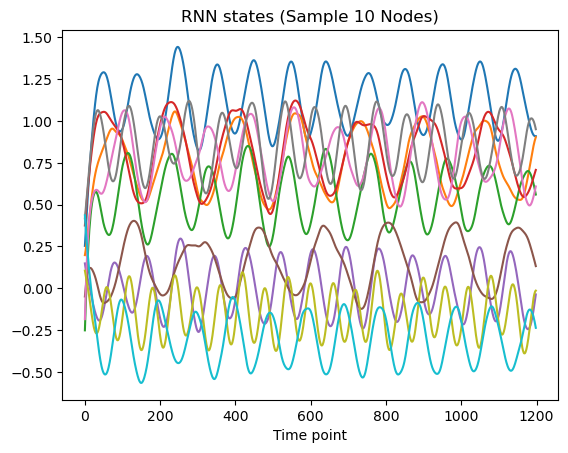

In [28]:
all_states = np.concatenate(states, axis=1)
for i in range(10):
    plt.plot(all_states[i, :])
plt.title("RNN states (Sample 10 Nodes)")
plt.xlabel("Time point")

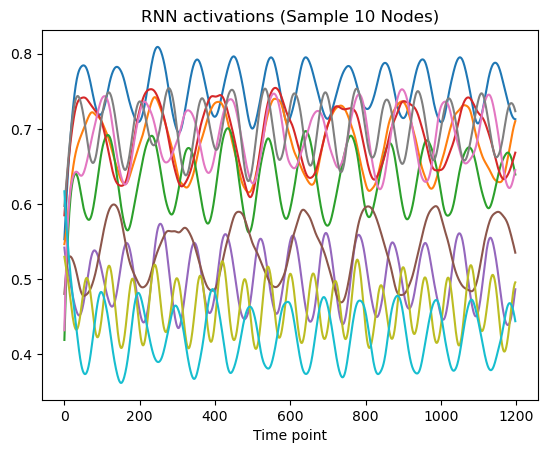

In [29]:
all_activations = np.concatenate(activations, axis=1)
for i in range(10):
    plt.plot(all_activations[i, :], label=f"Node {i}")
plt.title("RNN activations (Sample 10 Nodes)")
plt.xlabel("Time point")
# plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_wavebasis_activations.png")

### Hebbian learning with target

In [30]:
# Initializing matrix
num_nodes = 1000
np.random.seed(2)

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

In [31]:
# define targets
time_points = np.arange(6000)
targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5

# input basis functions
np.random.seed(2)
inputs = []
for i in range(num_nodes):
    freq = np.random.randint(10, 100)
    phase = np.random.randint(0, 100)
    this_row = np.sin((time_points-phase)/freq*np.pi)/4 + 0.5
    inputs.append(this_row)
inputs = np.array(inputs)

In [32]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type
init_output_weight_matrix = output_weight_matrix.copy()

# normalize
ext_weight_sum = 250
inh_weight_sum = 250
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [33]:
# # simulation data - correlation rule fails
# has_hebbian = True
# hebbian_lr = 0.003
# ext_weight_sum = 250
# inh_weight_sum = 250
# outputs, states, activations, output_weights = [], [], [], []
# for i in time_points:
    
#     # Creating RNN
#     network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
#               timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), target=inputs, shiftout=-2.5, gainout=1.15, basisset=True)
#     network.i = i
    
#     # forward
#     network.forward()
#     this_output = network.output.squeeze()
#     init_state = network.state.detach().numpy()

#     # prepare for hebbian learning
#     this_target = targets[i].item()
#     this_activation = network.activation.detach().numpy()
#     this_output_weight_matrix = network.output_weight_matrix.detach().numpy()

#     # update weights by hebbian learning
#     if has_hebbian:
#         # Calculate Hebbian weight updates
#         hebbian_update = this_target * this_activation.T
#         hebbian_update = hebbian_update * node_type
#         # Normalized Hebbian learning
#         tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
#         tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
#         tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
#         tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
#         tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
#         tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
#         tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
#         # update init weights
#         output_weight_matrix = tmp_output_weight_matrix.copy()

#     # save
#     outputs.append(this_output.detach().item())
#     states.append(init_state)
#     activations.append(this_activation)
#     output_weights.append(this_output_weight_matrix)

In [34]:
# simulation data - hcp
has_hebbian = True
hebbian_lr = 0.003
ext_weight_sum = 250
inh_weight_sum = 250
outputs, states, activations, output_weights = [], [], [], []
target_mean = 0
activation_mean = np.zeros_like(init_state)

for i in time_points:
    
    # Creating RNN
    network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
              timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), target=inputs, shiftout=-2.5, gainout=1.15, basisset=True)
    network.i = i
    
    # forward
    network.forward()
    this_output = network.output.squeeze()
    init_state = network.state.detach().numpy()

    # prepare for hebbian learning
    this_target = targets[i].item()
    this_activation = network.activation.detach().numpy()
    this_output_weight_matrix = network.output_weight_matrix.detach().numpy()
    target_mean = i/(i+1)*target_mean + this_target/(i+1)
    activation_mean = i/(i+1)*activation_mean + this_activation/(i+1)

    # update weights by hebbian learning
    if has_hebbian:
        # Calculate Hebbian weight updates
        hebbian_update = (this_target - target_mean) * (this_activation - activation_mean).T
        hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        output_weight_matrix = tmp_output_weight_matrix.copy()

    # save
    outputs.append(this_output.detach().item())
    states.append(init_state)
    activations.append(this_activation)
    output_weights.append(this_output_weight_matrix)

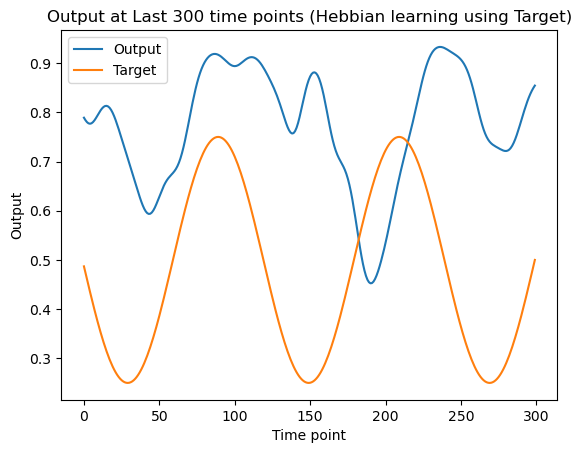

In [38]:
plt.plot(outputs[-300:], label='Output')
plt.plot(targets[-300:], label='Target')
plt.title('Output at Last 300 time points (Hebbian learning using Target)')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_wavebasis_outputhcp.png")

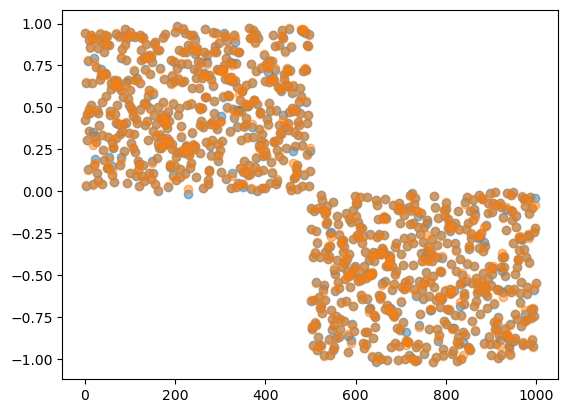

In [36]:
plt.plot(output_weights[-1].flatten(), 'o', alpha=0.5)
plt.plot(init_output_weight_matrix.flatten(), 'o', alpha=0.5)

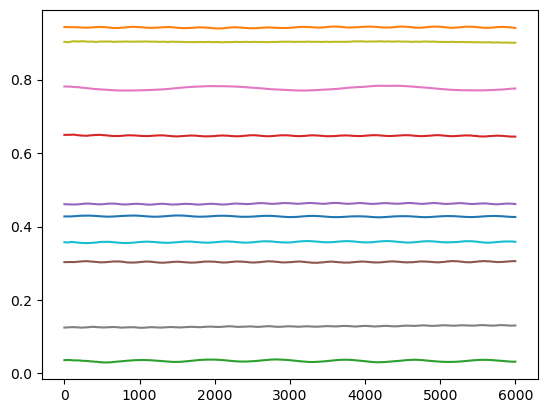

In [37]:
all_output_weights = np.concatenate(output_weights, axis=0).T
for i in range(10):
    plt.plot(all_output_weights[i, :])